# fig 2c analysis

In [1]:
import dask.dataframe as dd
from dask.distributed import LocalCluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns

In [2]:
cluster = LocalCluster(memory_limit='120GB', n_workers=10)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 30,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33665,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 30
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:38305,Total threads: 3
Dashboard: http://127.0.0.1:40729/status,Memory: 111.76 GiB
Nanny: tcp://127.0.0.1:42203,


统计gisaid每月序列数

In [3]:
gisaid_meta = dd.read_csv('../data/raw/metadata.tsv', sep='\t', usecols=['Collection date', 'Location', 'Sequence length'])
gisaid_meta.head()

,Collection date,Location,Sequence length
0,2021-03-30,Europe / Germany / Berlin,29640
1,2022-01-24,Asia / Indonesia / Jakarta,29684
2,2022-03-15,Europe / Denmark / Syddanmark,29795
3,2020-11-02,Europe / United Kingdom / England,29828
4,2021-04-03,Europe / Germany / Berlin,29626


In [4]:
gisaid_meta = gisaid_meta.loc[(gisaid_meta['Collection date'].str.count('-') >= 1) & 
                              (gisaid_meta['Location'].str.count('/') > 1) &
                              (gisaid_meta['Sequence length'] >= 27000)]
gisaid_meta.head()

,Collection date,Location,Sequence length
0,2021-03-30,Europe / Germany / Berlin,29640
1,2022-01-24,Asia / Indonesia / Jakarta,29684
2,2022-03-15,Europe / Denmark / Syddanmark,29795
3,2020-11-02,Europe / United Kingdom / England,29828
4,2021-04-03,Europe / Germany / Berlin,29626


In [5]:
def get_month(date_str):
    date_list = date_str.split('-')[:2]
    if len(date_list[1]) == 1:
        date_list[1] = '0' + date_list[1]
    return '-'.join(date_list)

In [6]:
gisaid_meta['continent'] = gisaid_meta['Location'].apply(lambda x: x.split('/')[0].strip(' '), meta=pd.Series(name='continent', dtype='object'))
gisaid_meta['month_date'] = gisaid_meta['Collection date'].apply(get_month, meta=pd.Series(name='month_date', dtype='object'))
gisaid_meta.head(n=100)

,Collection date,Location,Sequence length,continent,month_date
0,2021-03-30,Europe / Germany / Berlin,29640,Europe,2021-03
1,2022-01-24,Asia / Indonesia / Jakarta,29684,Asia,2022-01
2,2022-03-15,Europe / Denmark / Syddanmark,29795,Europe,2022-03
3,2020-11-02,Europe / United Kingdom / England,29828,Europe,2020-11
4,2021-04-03,Europe / Germany / Berlin,29626,Europe,2021-04
...,...,...,...,...,...
102,2022-02-08,Europe / United Kingdom / England,29778,Europe,2022-02
103,2021-09-02,North America / USA / California / Madera County,29775,North America,2021-09
104,2022-02-28,Europe / France / Ile-de-France,29787,Europe,2022-02
105,2021-12-13,North America / USA / California / Contra Cost...,29769,North America,2021-12


In [7]:
gisaid_meta_stat = gisaid_meta.groupby(['continent','month_date']).size().compute().reset_index(name='count')
gisaid_meta_stat

,continent,month_date,count
0,Africa,2020-04,731
1,Africa,2020-05,1281
2,Africa,2020-06,1198
3,Africa,2020-07,2359
4,Africa,2020-08,1168
...,...,...,...
224,Africa,2020-01,1
225,Asia,2013-07,1
226,Asia,2019-06,2
227,Asia,2017-08,1


独立重组事件结果

In [8]:
independent_recombination = pd.read_csv('data/Independent_recombination_event_1451_v1.csv', usecols=['collect_date', 'region'])
independent_recombination

,collect_date,region
0,2022-07-27,Europe
1,2022-06-29,Asia
2,2021-05-17,Europe
3,2022-05-24,Asia
4,2022-05-31,Europe
...,...,...
1446,2022-04-04,Europe
1447,2022-04-05,Oceania
1448,2022-04-07,Europe
1449,2022-04-10,Europe


In [9]:
independent_recombination['collect_date'] = independent_recombination['collect_date'].apply(get_month)
independent_recombination_count = independent_recombination.groupby(['collect_date','region']).size().reset_index(name='count')
independent_recombination_count.columns = ['month_date', 'continent', 'recombination_count']
independent_recombination_count

,month_date,continent,recombination_count
0,2020-06,North America,1
1,2020-08,Europe,1
2,2020-10,Asia,1
3,2020-10,Europe,3
4,2020-11,Europe,1
...,...,...,...
129,2022-12,South America,5
130,2023-01,Europe,1
131,2023-01,North America,5
132,2023-01,Oceania,1


创建基准地区+时间表格，并合并gisaid数据和重组结果

In [10]:
continents = []
month_dates = []
for continent in gisaid_meta_stat['continent'].unique():
    for date in pd.date_range(start='2020-06', end='2023-01', freq='MS').strftime('%Y-%m').tolist():
        continents.append(continent)
        month_dates.append(date)
all_continents_and_dates = pd.DataFrame({'continent': continents, 'month_date': month_dates})
all_continents_and_dates

,continent,month_date
0,Africa,2020-06
1,Africa,2020-07
2,Africa,2020-08
3,Africa,2020-09
4,Africa,2020-10
...,...,...
187,South America,2022-09
188,South America,2022-10
189,South America,2022-11
190,South America,2022-12


In [11]:
gisaid_meta_stat = all_continents_and_dates.merge(gisaid_meta_stat, on=['continent', 'month_date'], how='left')
gisaid_meta_stat = gisaid_meta_stat.merge(independent_recombination_count, on=['continent', 'month_date'], how='left')
gisaid_meta_stat.fillna(0, inplace=True)
gisaid_meta_stat

,continent,month_date,count,recombination_count
0,Africa,2020-06,1198,0.0
1,Africa,2020-07,2359,0.0
2,Africa,2020-08,1168,0.0
3,Africa,2020-09,1059,0.0
4,Africa,2020-10,1599,0.0
...,...,...,...,...
187,South America,2022-09,4466,0.0
188,South America,2022-10,3992,0.0
189,South America,2022-11,12955,3.0
190,South America,2022-12,8811,5.0


In [12]:
gisaid_meta_stat['recombination_rate'] = gisaid_meta_stat['recombination_count'] / gisaid_meta_stat['count']
gisaid_meta_stat

,continent,month_date,count,recombination_count,recombination_rate
0,Africa,2020-06,1198,0.0,0.000000
1,Africa,2020-07,2359,0.0,0.000000
2,Africa,2020-08,1168,0.0,0.000000
3,Africa,2020-09,1059,0.0,0.000000
4,Africa,2020-10,1599,0.0,0.000000
...,...,...,...,...,...
187,South America,2022-09,4466,0.0,0.000000
188,South America,2022-10,3992,0.0,0.000000
189,South America,2022-11,12955,3.0,0.000232
190,South America,2022-12,8811,5.0,0.000567


## GISAID Sequence Count vs Recombination Count

In [13]:
spearman_result = spearmanr(gisaid_meta_stat['count'], gisaid_meta_stat['recombination_count'])
spearman_result

SignificanceResult(statistic=0.7619983186431545, pvalue=1.056922063872193e-37)

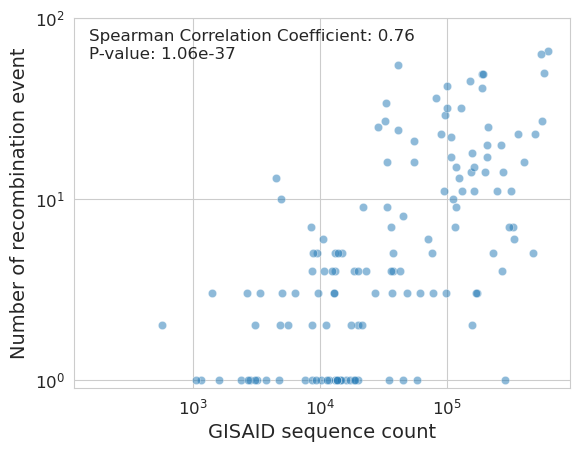

In [14]:
sns.scatterplot(data=gisaid_meta_stat, x='count', y='recombination_count', alpha=0.5)

plt.xlabel('GISAID sequence count', fontsize=14)
plt.ylabel('Number of recombination event', fontsize=14)
plt.text(150, 60, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}', fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.9, 100)
plt.tick_params(labelsize=12)

plt.savefig('../results/reviewer_1_3_part1.pdf')
plt.show()

In [15]:
continent_spearman = dict()
for continent in gisaid_meta_stat['continent'].unique():
    spearman_result = spearmanr(gisaid_meta_stat.loc[gisaid_meta_stat['continent'] == continent, 'count'], 
                                gisaid_meta_stat.loc[gisaid_meta_stat['continent'] == continent, 'recombination_count'])
    continent_spearman[continent] = spearman_result.pvalue
continent_spearman

{'Africa': 0.00018794552418710327,
 'Asia': 2.008143865211495e-07,
 'Europe': 0.00018332419753208236,
 'North America': 0.0002593045089571718,
 'Oceania': 1.4695800276384921e-06,
 'South America': 0.00012392179451501913}

In [16]:
def update_legend_handles_labels(handles, labels, continent_values):
    new_handles = []
    new_labels = []
    for handle, label in zip(handles, labels):
        if label in continent_values:
            new_label = f"{label} ({continent_values[label]:.2e})"
        else:
            new_label = label
        new_handles.append(handle)
        new_labels.append(new_label)
    return new_handles, new_labels

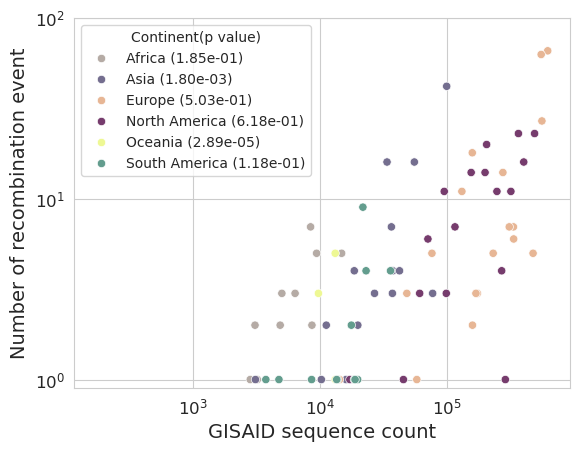

In [44]:
continent_colors = {'Africa': '#b5aba5', 'Asia': '#746e8f', 'Europe': '#e7b695', 'North America': '#763c6d', 'South America': '#639d8e', 'Oceania': '#eef894'}

scatter = sns.scatterplot(data=gisaid_meta_stat, x='count', y='recombination_count', hue='continent', palette=continent_colors)

plt.xlabel('GISAID sequence count', fontsize=14)
plt.ylabel('Number of recombination event', fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.ylim(0.9, 100)

handles, labels = scatter.get_legend_handles_labels()
new_handles, new_labels = update_legend_handles_labels(handles, labels, continent_spearman)
plt.legend(new_handles, new_labels, title='Continent(p value)', bbox_to_anchor=(0, 1), loc='upper left', fontsize=10, title_fontsize=10)
plt.tick_params(labelsize=12)

plt.savefig('../results/reviewer_1_3_part2.pdf')
plt.show()

## Recombination Rate

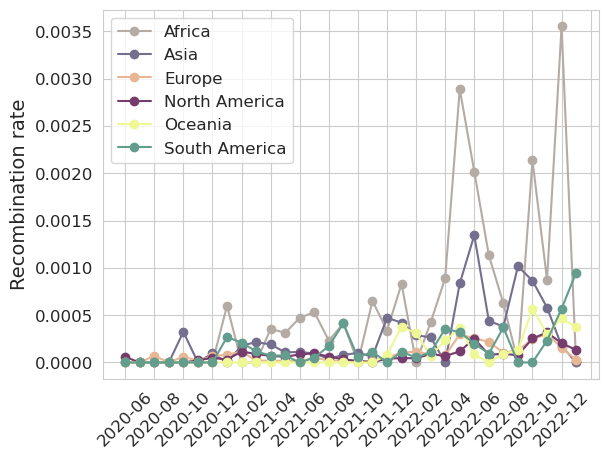

In [18]:
gisaid_meta_stat_plt = gisaid_meta_stat.set_index('month_date')

for name, group in gisaid_meta_stat_plt.groupby('continent'):
    plt.plot(group.index, group['recombination_rate'], marker='o', label=name, color=continent_colors[name])

plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=18))
plt.legend(fontsize=12)
plt.grid(True)
plt.ylabel('Recombination rate', fontsize=14)
plt.tick_params(labelsize=12)

plt.savefig('../results/reviewer_1_3_part3.pdf')
plt.show()

In [19]:
gisaid_meta_stat['time'] = pd.to_datetime(gisaid_meta_stat['month_date']).apply(lambda x: x.year + (x.month - 1) / 12)
gisaid_meta_stat

,continent,month_date,count,recombination_count,recombination_rate,time
0,Africa,2020-06,1198,0.0,0.000000,2020.416667
1,Africa,2020-07,2359,0.0,0.000000,2020.500000
2,Africa,2020-08,1168,0.0,0.000000,2020.583333
3,Africa,2020-09,1059,0.0,0.000000,2020.666667
4,Africa,2020-10,1599,0.0,0.000000,2020.750000
...,...,...,...,...,...,...
187,South America,2022-09,4466,0.0,0.000000,2022.666667
188,South America,2022-10,3992,0.0,0.000000,2022.750000
189,South America,2022-11,12955,3.0,0.000232,2022.833333
190,South America,2022-12,8811,5.0,0.000567,2022.916667


In [20]:
spearman_result = spearmanr(gisaid_meta_stat['recombination_rate'], gisaid_meta_stat['time'])
spearman_result

SignificanceResult(statistic=0.5840410954092309, pvalue=6.010151117360099e-19)

In [21]:
from scipy.stats import kruskal

# 将数据按照不同的continent分组
grouped_data = [group['recombination_rate'].values for name, group in gisaid_meta_stat.groupby('continent')]

# Kruskal-Wallis 检验
stat, p_value = kruskal(*grouped_data)

print(f'Kruskal-Wallis 检验统计量: {stat}, p值: {p_value}')


Kruskal-Wallis 检验统计量: 13.280952267312495, p值: 0.020883483514586677


In [22]:
import scikit_posthocs as sp

# Dunn's Test
dunn_result = sp.posthoc_dunn(gisaid_meta_stat, val_col='recombination_rate', group_col='continent', p_adjust='bonferroni')

dunn_result


,Africa,Asia,Europe,North America,Oceania,South America
Africa,1.000000,1.000000,1.0,0.942822,0.033320,1.0
Asia,1.000000,1.000000,1.0,1.000000,0.054299,1.0
Europe,1.000000,1.000000,1.0,1.000000,1.000000,1.0
North America,0.942822,1.000000,1.0,1.000000,1.000000,1.0
Oceania,0.033320,0.054299,1.0,1.000000,1.000000,1.0
South America,1.000000,1.000000,1.0,1.000000,1.000000,1.0


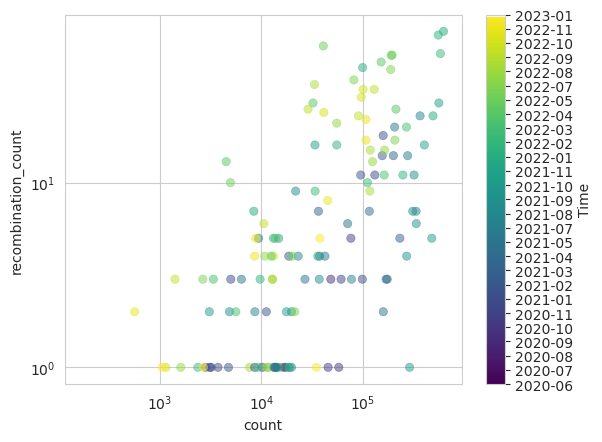

In [23]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=gisaid_meta_stat['time'].min(), vmax=gisaid_meta_stat['time'].max())
colors = cmap(norm(gisaid_meta_stat['time']))

fig, ax = plt.subplots()

sns.scatterplot(data=gisaid_meta_stat, x='count', y='recombination_count', palette=None, alpha=0.5, edgecolor=None, ax=ax, color=colors)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Time')
cbar.set_ticks(np.arange(gisaid_meta_stat['time'].min(), gisaid_meta_stat['time'].max() + 0.1, 0.1))
cbar.ax.set_yticklabels([f'{int(tick):04d}-{int((tick - int(tick)) * 12) + 1:02d}' for tick in cbar.get_ticks()])

plt.xscale('log')
plt.yscale('log')

plt.show()

## GISAID Sequence Count vs Recombination Rate

In [24]:
spearman_result = spearmanr(gisaid_meta_stat['recombination_rate'], gisaid_meta_stat['count'])
spearman_result

SignificanceResult(statistic=0.20922624622079267, pvalue=0.003585509118681218)

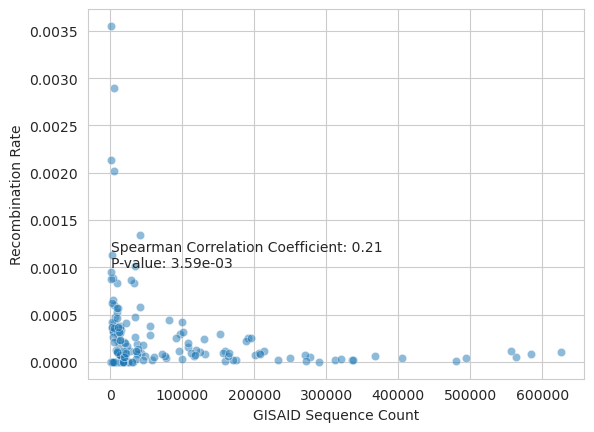

In [25]:
sns.scatterplot(data=gisaid_meta_stat, x='count', y='recombination_rate', alpha=0.5)

plt.xlabel('GISAID Sequence Count')
plt.ylabel('Recombination Rate')
plt.text(1e3, 1e-3, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}', fontsize=10)

plt.show()

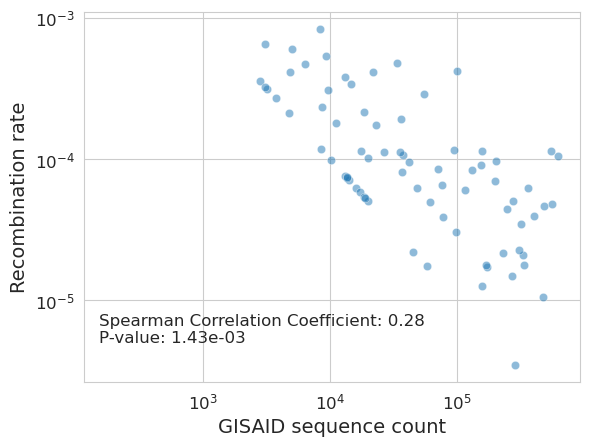

In [45]:
sns.scatterplot(data=gisaid_meta_stat, x='count', y='recombination_rate', alpha=0.5)

plt.xlabel('GISAID sequence count', fontsize=14)
plt.ylabel('Recombination rate', fontsize=14)
plt.text(150, 5e-6, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}', fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=12)

plt.savefig('../results/reviewer_1_3_part4.pdf')
plt.show()

In [27]:
continent_spearman = dict()
for continent in gisaid_meta_stat['continent'].unique():
    spearman_result = spearmanr(gisaid_meta_stat.loc[gisaid_meta_stat['continent'] == continent, 'count'],
                                gisaid_meta_stat.loc[gisaid_meta_stat['continent'] == continent, 'recombination_rate'])
    continent_spearman[continent] = spearman_result.pvalue
continent_spearman

{'Africa': 0.1854580972071115,
 'Asia': 0.001803946047825403,
 'Europe': 0.502975186907082,
 'North America': 0.6175729695340078,
 'Oceania': 2.892493271188283e-05,
 'South America': 0.11820847934557305}

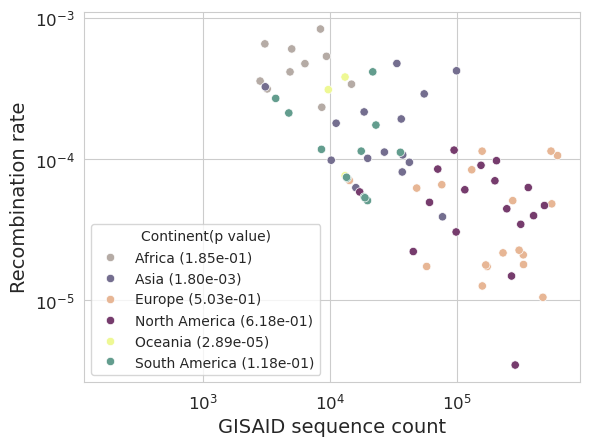

In [46]:
scatter = sns.scatterplot(data=gisaid_meta_stat, x='count', y='recombination_rate', hue='continent', palette=continent_colors)

plt.xlabel('GISAID sequence count', fontsize=14)
plt.ylabel('Recombination rate', fontsize=14)

plt.xscale('log')
plt.yscale('log')

handles, labels = scatter.get_legend_handles_labels()
new_handles, new_labels = update_legend_handles_labels(handles, labels, continent_spearman)
plt.legend(new_handles, new_labels, title='Continent(p value)', bbox_to_anchor=(0, 0), loc='lower left', fontsize=10, title_fontsize=10)
plt.tick_params(labelsize=12)

plt.savefig('../results/reviewer_1_3_part5.pdf')
plt.show()

## Co-infection Rate vs Recombination Rate

In [30]:
co_infection = pd.read_csv('../data/raw/datafile4.csv',  # from https://www.nature.com/articles/s41467-023-43391-z
                           usecols=['collection_date', 'collection_date_valid', 'country_name'])
co_infection = co_infection.loc[(~co_infection['collection_date'].isna()) & 
                                (co_infection['collection_date_valid'])]
co_infection

,collection_date,collection_date_valid,country_name
0,2021-06-01,True,United States
1,2021-04-10,True,United States
2,2022-01-09,True,United States
3,2020-12-11,True,United States
4,2021-12-14,True,France
...,...,...,...
7695,2022-06-11,True,United States
7696,2021-12-16,True,United States
7697,2022-01-06,True,United States
7698,2022-06-05,True,United States


In [31]:
co_infection['country_name'].unique()

array(['United States', 'France', 'South Africa', 'Norway', 'India',
       'Brazil', 'Mauritius', 'Australia', 'Cameroon', 'United Kingdom',
       'Ireland', 'Netherlands', 'Spain', 'Zimbabwe', 'Namibia', 'Angola',
       'Slovakia', 'Estonia', 'Greece', 'Italy', 'Pakistan', 'Portugal',
       'Finland', 'Ghana', 'Switzerland', 'Germany', 'Mexico', 'Israel',
       'Malawi', 'Iraq', 'Bangladesh'], dtype=object)

In [32]:
countries = {
    'United States': 'North America',
    'France': 'Europe',
    'South Africa': 'Africa',
    'Norway': 'Europe',
    'India': 'Asia',
    'Brazil': 'South America',
    'Mauritius': 'Africa',
    'Australia': 'Oceania',
    'Cameroon': 'Africa',
    'United Kingdom': 'Europe',
    'Ireland': 'Europe',
    'Netherlands': 'Europe',
    'Spain': 'Europe',
    'Zimbabwe': 'Africa',
    'Namibia': 'Africa',
    'Angola': 'Africa',
    'Slovakia': 'Europe',
    'Estonia': 'Europe',
    'Greece': 'Europe',
    'Italy': 'Europe',
    'Pakistan': 'Asia',
    'Portugal': 'Europe',
    'Finland': 'Europe',
    'Ghana': 'Africa',
    'Switzerland': 'Europe',
    'Germany': 'Europe',
    'Mexico': 'North America',
    'Israel': 'Asia',
    'Malawi': 'Africa',
    'Iraq': 'Asia',
    'Bangladesh': 'Asia'
}

In [33]:
co_infection['continent'] = co_infection['country_name'].apply(lambda x: countries[x])
co_infection['month_date'] = pd.to_datetime(co_infection['collection_date'])
co_infection['month_date'] = co_infection['month_date'].dt.strftime('%Y-%m')
co_infection

,collection_date,collection_date_valid,country_name,continent,month_date
0,2021-06-01,True,United States,North America,2021-06
1,2021-04-10,True,United States,North America,2021-04
2,2022-01-09,True,United States,North America,2022-01
3,2020-12-11,True,United States,North America,2020-12
4,2021-12-14,True,France,Europe,2021-12
...,...,...,...,...,...
7695,2022-06-11,True,United States,North America,2022-06
7696,2021-12-16,True,United States,North America,2021-12
7697,2022-01-06,True,United States,North America,2022-01
7698,2022-06-05,True,United States,North America,2022-06


In [34]:
co_infection_stat = co_infection.groupby(['continent', 'month_date']).size().reset_index(name='co_infection_count')
co_infection_stat

,continent,month_date,co_infection_count
0,Africa,2020-09,4
1,Africa,2020-10,6
2,Africa,2020-11,3
3,Africa,2020-12,5
4,Africa,2021-01,4
...,...,...,...
61,North America,2022-06,83
62,Oceania,2021-04,1
63,Oceania,2021-12,2
64,Oceania,2022-01,4


In [35]:
gisaid_meta_stat = gisaid_meta_stat.merge(co_infection_stat, on=['continent', 'month_date'], how='left')
gisaid_meta_stat.fillna(0, inplace=True)
gisaid_meta_stat['co_infection_rate'] = gisaid_meta_stat['co_infection_count'] / gisaid_meta_stat['count'].sum()
gisaid_meta_stat

,continent,month_date,count,recombination_count,recombination_rate,time,co_infection_count,co_infection_rate
0,Africa,2020-06,1198,0.0,0.000000,2020.416667,0.0,0.000000e+00
1,Africa,2020-07,2359,0.0,0.000000,2020.500000,0.0,0.000000e+00
2,Africa,2020-08,1168,0.0,0.000000,2020.583333,0.0,0.000000e+00
3,Africa,2020-09,1059,0.0,0.000000,2020.666667,4.0,2.962391e-07
4,Africa,2020-10,1599,0.0,0.000000,2020.750000,6.0,4.443586e-07
...,...,...,...,...,...,...,...,...
187,South America,2022-09,4466,0.0,0.000000,2022.666667,0.0,0.000000e+00
188,South America,2022-10,3992,0.0,0.000000,2022.750000,0.0,0.000000e+00
189,South America,2022-11,12955,3.0,0.000232,2022.833333,0.0,0.000000e+00
190,South America,2022-12,8811,5.0,0.000567,2022.916667,0.0,0.000000e+00


In [36]:
gisaid_meta_stat['month_date'] = pd.to_datetime(gisaid_meta_stat['month_date'])
gisaid_meta_stat = gisaid_meta_stat.loc[gisaid_meta_stat['month_date'] <= pd.to_datetime('2022-02')]
gisaid_meta_stat

,continent,month_date,count,recombination_count,recombination_rate,time,co_infection_count,co_infection_rate
0,Africa,2020-06-01,1198,0.0,0.000000,2020.416667,0.0,0.000000e+00
1,Africa,2020-07-01,2359,0.0,0.000000,2020.500000,0.0,0.000000e+00
2,Africa,2020-08-01,1168,0.0,0.000000,2020.583333,0.0,0.000000e+00
3,Africa,2020-09-01,1059,0.0,0.000000,2020.666667,4.0,2.962391e-07
4,Africa,2020-10-01,1599,0.0,0.000000,2020.750000,6.0,4.443586e-07
...,...,...,...,...,...,...,...,...
176,South America,2021-10-01,18655,1.0,0.000054,2021.750000,0.0,0.000000e+00
177,South America,2021-11-01,17676,2.0,0.000113,2021.833333,0.0,0.000000e+00
178,South America,2021-12-01,17606,0.0,0.000000,2021.916667,0.0,0.000000e+00
179,South America,2022-01-01,36019,4.0,0.000111,2022.000000,0.0,0.000000e+00


In [37]:
spearman_result = spearmanr(gisaid_meta_stat['co_infection_rate'], gisaid_meta_stat['recombination_rate'])
spearman_result

SignificanceResult(statistic=0.281187859017993, pvalue=0.0014253067245928596)

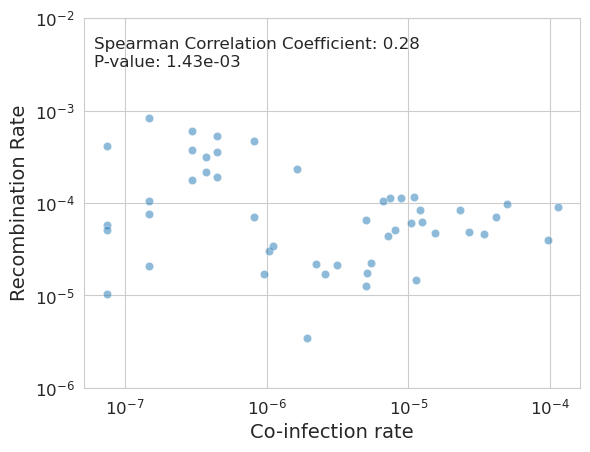

In [47]:
sns.scatterplot(data=gisaid_meta_stat, x='co_infection_rate', y='recombination_rate', alpha=0.5)

plt.xlabel('Co-infection rate', fontsize=14)
plt.ylabel('Recombination Rate', fontsize=14)
plt.text(6e-8, 3e-3, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}', fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6, 1e-2)
plt.tick_params(labelsize=12)

plt.savefig('../results/reviewer_1_3_part6.pdf')
plt.show()

In [58]:
continent_spearman = dict()
for continent in gisaid_meta_stat['continent'].unique():
    spearman_result = spearmanr(gisaid_meta_stat.loc[gisaid_meta_stat['continent'] == continent, 'co_infection_rate'],
                                gisaid_meta_stat.loc[gisaid_meta_stat['continent'] == continent, 'recombination_rate'])
    continent_spearman[continent] = spearman_result.pvalue
continent_spearman

{'Africa': 0.7091895382913205,
 'Asia': 0.11701257657466124,
 'Europe': 0.0010824331115753942,
 'North America': 0.0002870944358763082,
 'Oceania': 0.0015205530565282354,
 'South America': 0.8685522810545498}

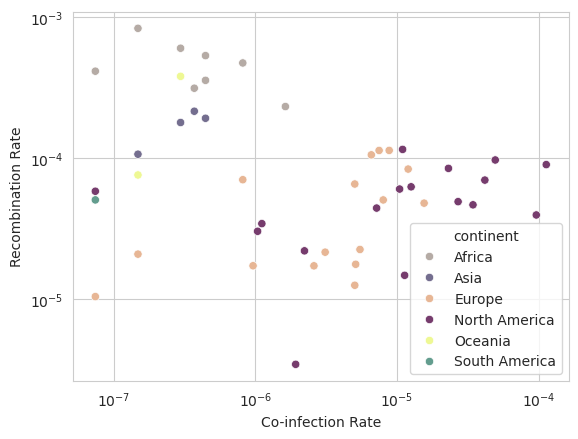

In [57]:
sns.scatterplot(data=gisaid_meta_stat, x='co_infection_rate', y='recombination_rate', hue='continent', palette=continent_colors)

plt.xlabel('Co-infection Rate')
plt.ylabel('Recombination Rate')

plt.xscale('log')
plt.yscale('log')

plt.show()

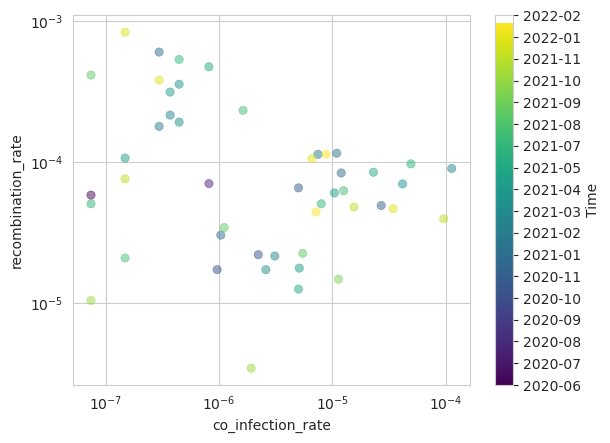

In [170]:
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=gisaid_meta_stat['time'].min(), vmax=gisaid_meta_stat['time'].max())
colors = cmap(norm(gisaid_meta_stat['time']))

fig, ax = plt.subplots()

sns.scatterplot(data=gisaid_meta_stat, x='co_infection_rate', y='recombination_rate', palette=None, alpha=0.5, edgecolor=None, ax=ax, color=colors)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Time')
cbar.set_ticks(np.arange(gisaid_meta_stat['time'].min(), gisaid_meta_stat['time'].max() + 0.1, 0.1))
cbar.ax.set_yticklabels([f'{int(tick):04d}-{int((tick - int(tick)) * 12) + 1:02d}' for tick in cbar.get_ticks()])

plt.xscale('log')
plt.yscale('log')

plt.show()

# breakpoint analysis

In [59]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
from tqdm import tqdm

In [60]:
entropy_df = pd.read_csv('data/nextstrain_ncov_gisaid_global_6m_diversity.tsv', sep='\t') # from nextclade
entropy_df

,base,entropy
0,1,0.002
1,2,0.026
2,8,0.002
3,9,0.004
4,10,0.068
...,...,...
7941,29886,0.005
7942,29890,0.002
7943,29892,0.002
7944,29893,0.002


In [61]:
def find_boundaries(s):
    x_to_y = []
    y_to_x = []
    x_count = 0
    y_count = 0

    for i in range(len(s)):
        if s[i] == 'X':
            x_count += 1
        else:
            y_count += 1

        if i < len(s) - 1:
            if s[i] == 'X' and s[i+1] == 'Y':
                x_to_y.append([x_count - 1, y_count])
            elif s[i] == 'Y' and s[i+1] == 'X':
                y_to_x.append([x_count, y_count - 1])

    return x_to_y, y_to_x

In [62]:
independent_recombination = pd.read_csv('data/Independent_recombination_event_1451_v1.csv', usecols=['mutation_pattern', 'X_mutations', 'Y_mutations'])
independent_recombination

,mutation_pattern,X_mutations,Y_mutations
0,XXXXXXXXXYYYYYYYYYYYY,405_G/15738_T/15939_C/16342_C/17859_C/21987_A/...,22674_T/22679_C/22686_T/22688_G/22786_C/22813_...
1,XXXXXXXXXXYYYYYYYYYYYY,405_G/15738_T/15939_C/16342_C/17859_C/21810_C/...,22674_T/22679_C/22686_T/22688_G/22786_C/22813_...
2,XXXXXXXYYYYYXX,9344_T/9424_G/19955_T/20055_G/22674_T/22686_T/...,22882_G/22917_G/23055_G/23063_T/23075_C
3,YYYXXXXXXXYYYYY,9344_T/9424_G/19955_T/20055_G/22674_T/22686_T/...,1627_T/6979_G/7086_A/26625_T/27038_G/27371_T/2...
4,XYYYYXXXX,21987_A/25000_T/26529_A/27438_C/29666_T,22917_G/23055_G/23063_T/23075_C
...,...,...,...
1446,XXXXXXXXYYYY,9430_T/19955_T/20055_G/22578_A/22674_T/22679_C...,22775_A/22786_C/22792_T/22882_G
1447,YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY...,28881_A/28882_A/28883_C/28887_T,670_G/2790_T/4184_A/4321_T/9344_T/9534_T/9866_...
1448,XXYYYYXXXXXXX,686_---------/1453_C/23535_G/27259_C/27382_C/2...,22786_C/22813_T/22882_G/22917_G
1449,XXXXYYYYYXX,2790_T/9866_T/10198_T/19955_T/25000_T/25584_T,21762_T/21765_------/21846_T/21987_---------/2...


In [63]:
breakpoints = []
for _, row in tqdm(independent_recombination.iterrows(), total=independent_recombination.shape[0]):
    xy_breakpoint, yx_breakpoint = find_boundaries(row['mutation_pattern'])
    for pos in xy_breakpoint:
        start = int(row['X_mutations'].split('/')[pos[0]].split('_')[0])
        end = int(row['Y_mutations'].split('/')[pos[1]].split('_')[0])
        breakpoints.append((end + start)/2)
        
    for pos in yx_breakpoint:
        start = int(row['Y_mutations'].split('/')[pos[1]].split('_')[0])
        end = int(row['X_mutations'].split('/')[pos[0]].split('_')[0])
        breakpoints.append((end + start)/2)
breakpoints[:10]

100%|██████████| 1451/1451 [00:00<00:00, 22093.40it/s]


[22437.0,
 22437.0,
 22785.0,
 25256.5,
 24656.5,
 8215.0,
 22452.0,
 24037.5,
 22785.0,
 25256.5]

In [64]:
with open('data/fv.txt', 'r') as f:
    reader = csv.reader(f)
    data = [row for row in reader]

fv_dict = {}
mutation = []
for row in data:
    for mut in row[2:]:
        if mut == '':
            continue
        start = int(mut.split('_')[0])
        if mut[-1] == '-':
            for i in range(mut.count('-')):
                mutation.append(start + i)
        else:
            mutation.append(start)
mutation[:10]

[8782, 28144, 8782, 17747, 17858, 18060, 28144, 8782, 24370, 28144]

In [65]:
positions = []
total_entropy_list = []
total_recombination_list = []
total_mutation_list = []
for i in range(1, 30000, 500):
    total_entropy = entropy_df.loc[(entropy_df['base'] >= i) & (entropy_df['base'] <= i + 499)]['entropy'].sum()
    total_breakpoint = len([breakpoint for breakpoint in breakpoints if (i <= breakpoint <= i + 499)])
    total_mutation = len([pos for pos in mutation if (i <= pos <= i + 499)])
    positions.append(i)
    total_entropy_list.append(total_entropy)
    total_recombination_list.append(total_breakpoint)
    total_mutation_list.append(total_mutation)
entropy_vs_recombinant_count_pos = pd.DataFrame(
    {'position': positions, 'total_entropy': total_entropy_list, 'total_recombination': total_recombination_list, 'total_mutation': total_mutation_list})
entropy_vs_recombinant_count_pos

,position,total_entropy,total_recombination,total_mutation
0,1,2.802,0,232
1,501,2.254,1,1171
2,1001,1.034,1,488
3,1501,1.144,10,463
4,2001,0.981,3,228
5,2501,1.329,2,927
6,3001,1.368,1,2355
7,3501,1.497,1,396
8,4001,1.590,1,1564
9,4501,0.788,0,254


In [66]:
covid19_gene = pd.read_csv('data/SARS_CoV_2_detail.csv', usecols=['gene', 'genomePos'])
covid19_gene

,gene,genomePos
0,ORF1ab,266
1,ORF1ab,267
2,ORF1ab,268
3,ORF1ab,269
4,ORF1ab,270
...,...,...
29260,NS10,29670
29261,NS10,29671
29262,NS10,29672
29263,NS10,29673


In [67]:
gene_pos = dict()
for gene in covid19_gene['gene'].unique():
    start = covid19_gene.loc[covid19_gene['gene'] == gene, 'genomePos'].min()
    end = covid19_gene.loc[covid19_gene['gene'] == gene, 'genomePos'].max()
    gene_pos[gene] = [start, end]
gene_pos

{'ORF1ab': [266, 21555],
 'Spike': [21563, 25384],
 'NS3': [25393, 26220],
 'E': [26245, 26472],
 'M': [26523, 27191],
 'NS6': [27202, 27387],
 'NS7a': [27394, 27759],
 'NS7b': [27756, 27887],
 'NS8': [27894, 28259],
 'N': [28274, 29533],
 'NS10': [29558, 29674]}

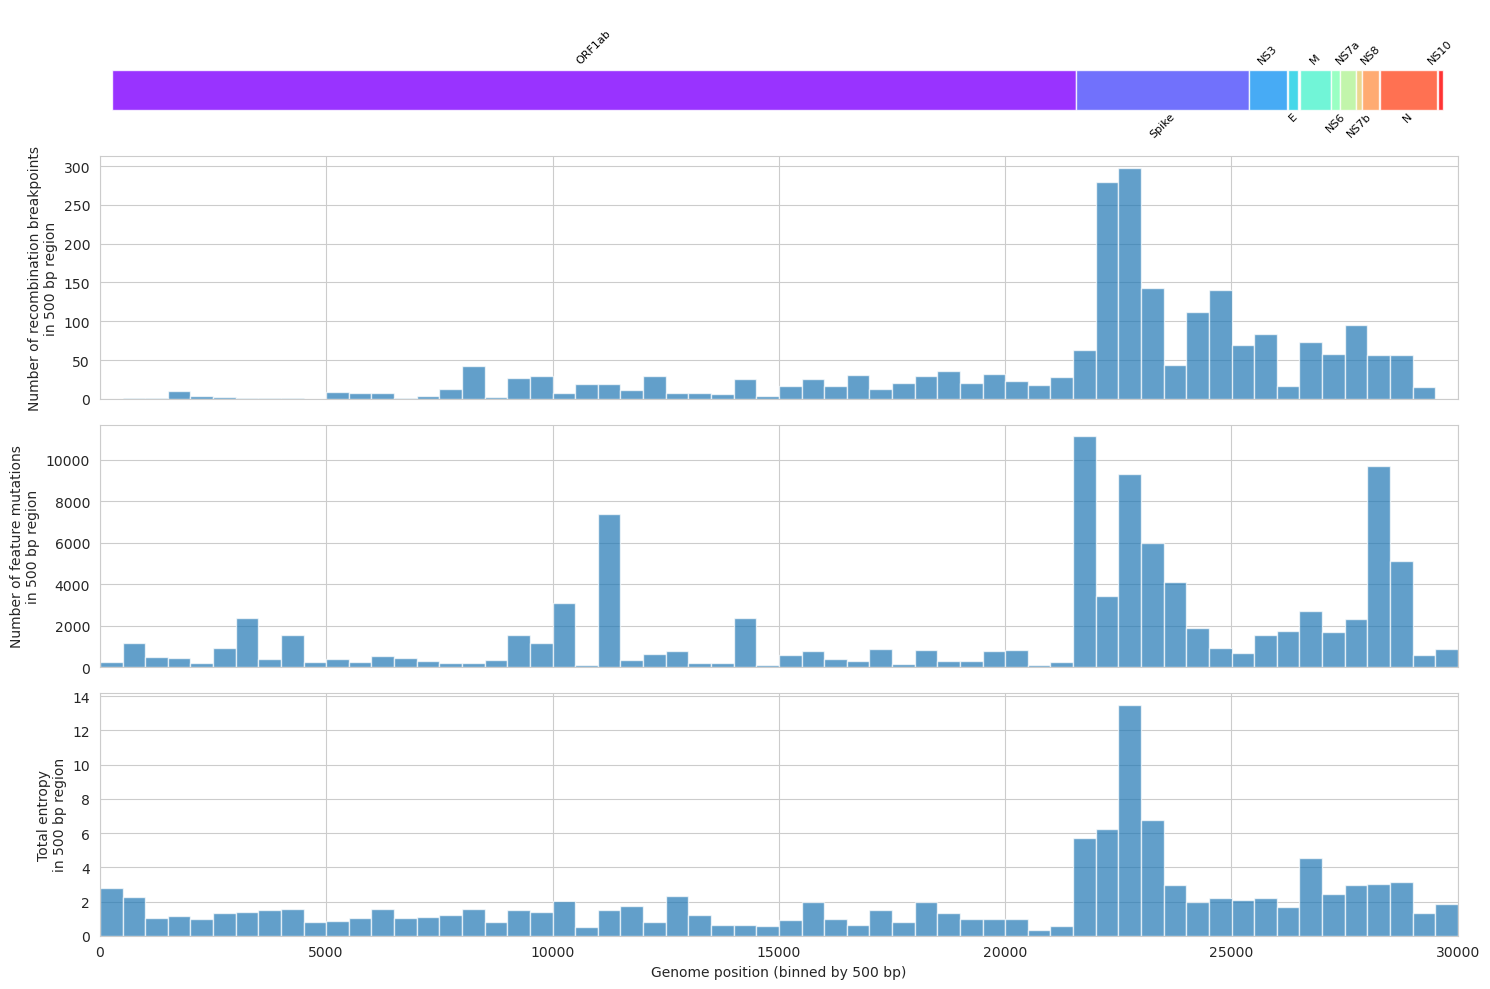

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 2, 2, 2]})
plt.subplots_adjust(hspace=0.05)

# 基因组示意图
colors = plt.cm.rainbow(np.linspace(0, 1, len(gene_pos)))

for i, ((gene, (start, end)), color) in enumerate(zip(gene_pos.items(), colors)):
    ax1.barh(0, end-start, left=start, height=0.5, align='center', color=color, alpha=0.8)

    if i % 2 == 0:  # 偶数索引在上方
        y_pos = 0.3
        va = 'bottom'
    else:  # 奇数索引在下方
        y_pos = -0.25
        va = 'top'

    ax1.text((start+end)/2, y_pos, gene, ha='center', va=va, rotation=45, fontsize=8, color='black')

ax1.grid(False)
ax1.set_ylim(-0.5, 1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_yticks([])

# 三张直方图
ax2.bar(entropy_vs_recombinant_count_pos['position'], entropy_vs_recombinant_count_pos['total_recombination'], width=500, align='edge', alpha=0.7)
ax2.set_ylabel('Number of recombination breakpoints\nin 500 bp region')
ax3.bar(entropy_vs_recombinant_count_pos['position'], entropy_vs_recombinant_count_pos['total_mutation'], width=500, align='edge', alpha=0.7)
ax3.set_ylabel('Number of feature mutations\nin 500 bp region')
ax4.bar(entropy_vs_recombinant_count_pos['position'], entropy_vs_recombinant_count_pos['total_entropy'], width=500, align='edge', alpha=0.7)
ax4.set_ylabel('Total entropy\nin 500 bp region')

ax4.set_xlabel('Genome position (binned by 500 bp)')

plt.xlim(0, 30000)
plt.tight_layout()
plt.savefig('../results/reviewer_1_4_part1.svg')
plt.show()

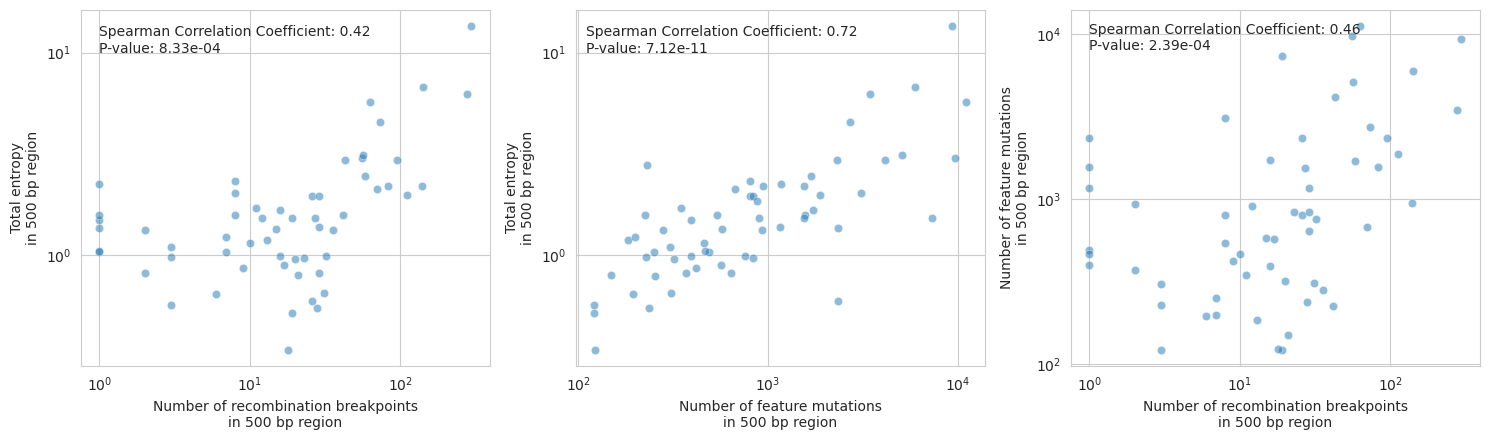

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

spearman_result = spearmanr(entropy_vs_recombinant_count_pos['total_recombination'], entropy_vs_recombinant_count_pos['total_entropy'])
sns.scatterplot(data=entropy_vs_recombinant_count_pos, x='total_recombination', y='total_entropy', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Number of recombination breakpoints\nin 500 bp region')
axes[0].set_ylabel('Total entropy\nin 500 bp region')
axes[0].text(1, 10, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

spearman_result = spearmanr(entropy_vs_recombinant_count_pos['total_mutation'], entropy_vs_recombinant_count_pos['total_entropy'])
sns.scatterplot(data=entropy_vs_recombinant_count_pos, x='total_mutation', y='total_entropy', alpha=0.5, ax=axes[1])
axes[1].set_xlabel('Number of feature mutations\nin 500 bp region')
axes[1].set_ylabel('Total entropy\nin 500 bp region')
axes[1].text(110, 10, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

spearman_result = spearmanr(entropy_vs_recombinant_count_pos['total_recombination'], entropy_vs_recombinant_count_pos['total_mutation'])
sns.scatterplot(data=entropy_vs_recombinant_count_pos, x='total_recombination', y='total_mutation', alpha=0.5, ax=axes[2])
axes[2].set_xlabel('Number of recombination breakpoints\nin 500 bp region')
axes[2].set_ylabel('Number of feature mutations\nin 500 bp region')
axes[2].text(1, 8000, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}')
axes[2].set_xscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig('../results/reviewer_1_4_part2.svg')
plt.show()

In [70]:
genes = []
total_entropy_list = []
total_recombination_list = []
total_mutation_list = []
for gene in gene_pos.keys():
    start, end = gene_pos[gene]
    genes.append(gene)
    total_entropy = entropy_df.loc[(entropy_df['base'] >= start) & (entropy_df['base'] <= end)]['entropy'].sum()
    total_breakpoint = len([breakpoint for breakpoint in breakpoints if (start <= breakpoint <= end)])
    total_mutation = len([pos for pos in mutation if (start <= pos <= end)])
    total_entropy_list.append(total_entropy)
    total_recombination_list.append(total_breakpoint)
    total_mutation_list.append(total_mutation)
entropy_vs_recombinant_count_gene = pd.DataFrame(
    {'gene': genes, 'total_entropy': total_entropy_list, 'total_recombination': total_recombination_list, 'total_mutation': total_mutation_list})
entropy_vs_recombinant_count_gene

,gene,total_entropy,total_recombination,total_mutation
0,ORF1ab,50.624,611,35301
1,Spike,40.782,1125,36982
2,NS3,3.722,113,2886
3,E,0.821,5,855
4,M,4.793,90,2891
5,NS6,1.862,24,1432
6,NS7a,1.324,68,830
7,NS7b,1.277,46,1008
8,NS8,1.502,30,1954
9,N,6.574,102,13562


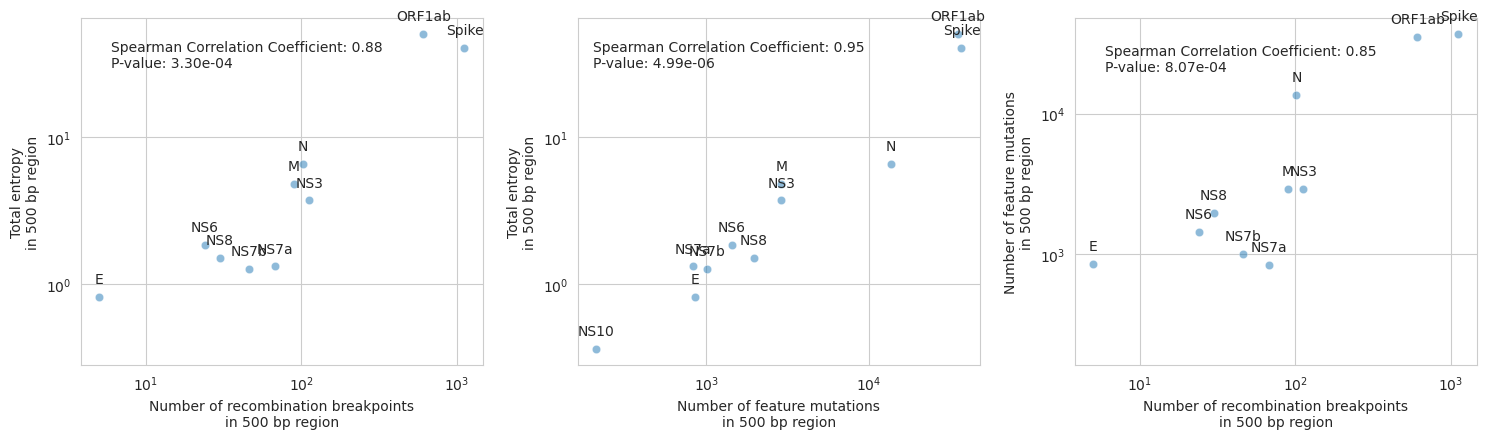

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

spearman_result = spearmanr(entropy_vs_recombinant_count_gene['total_recombination'], entropy_vs_recombinant_count_gene['total_entropy'])
sns.scatterplot(data=entropy_vs_recombinant_count_gene, x='total_recombination', y='total_entropy', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Number of recombination breakpoints\nin 500 bp region')
axes[0].set_ylabel('Total entropy\nin 500 bp region')
axes[0].text(6, 30, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}')
for i, txt in enumerate(entropy_vs_recombinant_count_gene['gene']):
    axes[0].annotate(txt, (entropy_vs_recombinant_count_gene['total_recombination'][i], entropy_vs_recombinant_count_gene['total_entropy'][i]),
                 textcoords="offset points", xytext=(0,10), ha='center')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

spearman_result = spearmanr(entropy_vs_recombinant_count_gene['total_mutation'], entropy_vs_recombinant_count_gene['total_entropy'])
sns.scatterplot(data=entropy_vs_recombinant_count_gene, x='total_mutation', y='total_entropy', alpha=0.5, ax=axes[1])
axes[1].set_xlabel('Number of feature mutations\nin 500 bp region')
axes[1].set_ylabel('Total entropy\nin 500 bp region')
axes[1].text(200, 30, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}')
for i, txt in enumerate(entropy_vs_recombinant_count_gene['gene']):
    axes[1].annotate(txt, (entropy_vs_recombinant_count_gene['total_mutation'][i], entropy_vs_recombinant_count_gene['total_entropy'][i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

spearman_result = spearmanr(entropy_vs_recombinant_count_gene['total_recombination'], entropy_vs_recombinant_count_gene['total_mutation'])
sns.scatterplot(data=entropy_vs_recombinant_count_gene, x='total_recombination', y='total_mutation', alpha=0.5, ax=axes[2])
axes[2].set_xlabel('Number of recombination breakpoints\nin 500 bp region')
axes[2].set_ylabel('Number of feature mutations\nin 500 bp region')
axes[2].text(6, 2e4, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}')
for i, txt in enumerate(entropy_vs_recombinant_count_gene['gene']):
    axes[2].annotate(txt, (entropy_vs_recombinant_count_gene['total_recombination'][i], entropy_vs_recombinant_count_gene['total_mutation'][i]),
                     textcoords="offset points", xytext=(0,10), ha='center')
axes[2].set_xscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.savefig('../results/reviewer_1_4_part3.svg')
plt.show()

# fig 5c analysis

In [1]:
import csv

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns

In [2]:
recom_with_lineage = pd.read_csv('data/UAB4_gephi_stas_hC939.csv', names=['linageA', 'linageB','count'])
recom_with_lineage = recom_with_lineage[recom_with_lineage['count'] > 1]
recom_with_lineage

,linageA,linageB,count
0,BJ.1,BM.1.1.1,44
1,BA.5,BA.2.17,12
2,BA.1.1*,BA.2.9*,12
3,BA.1.9,BA.2.9*,10
4,BA.1.1*,BA.2.23,8
...,...,...,...
156,B.1.351.2,B.1.1.7*,2
157,B.1.1.7*,B.1.525,2
158,B.1.526,B.1.637,2
159,B.1.1.7*,B.1.637,2


In [3]:
recom_with_lineage['linage_pair'] = recom_with_lineage.apply(lambda row: '-'.join(sorted([row['linageA'], row['linageB']])).replace('*', ''), axis=1)
recom_with_lineage

,linageA,linageB,count,linage_pair
0,BJ.1,BM.1.1.1,44,BJ.1-BM.1.1.1
1,BA.5,BA.2.17,12,BA.2.17-BA.5
2,BA.1.1*,BA.2.9*,12,BA.1.1-BA.2.9
3,BA.1.9,BA.2.9*,10,BA.1.9-BA.2.9
4,BA.1.1*,BA.2.23,8,BA.1.1-BA.2.23
...,...,...,...,...
156,B.1.351.2,B.1.1.7*,2,B.1.1.7-B.1.351.2
157,B.1.1.7*,B.1.525,2,B.1.1.7-B.1.525
158,B.1.526,B.1.637,2,B.1.526-B.1.637
159,B.1.1.7*,B.1.637,2,B.1.1.7-B.1.637


In [4]:
recom_with_lineage_pair = recom_with_lineage.groupby('linage_pair')['count'].sum().reset_index()
recom_with_lineage_pair

,linage_pair,count
0,AH.3-B.1.595,3
1,AY.103-B.1.1.7,2
2,AY.111-BA.1.1,3
3,AY.112-AY.14,2
4,AY.112-AY.26,6
...,...,...
149,BJ.1-BM.1.1,9
150,BJ.1-BM.1.1.1,44
151,BM.1.1.1-BQ.1.1.17,3
152,BM.1.1.1-BQ.1.23,2


In [5]:
with open('data/fv.txt', 'r') as f:
    reader = csv.reader(f)
    data = [row for row in reader]

fv_dict = {}
mutation = []
for row in data:
    fv_dict[row[0]] = set(row[2:])
    mutation.extend(row[2:])
mutation = set(mutation)
fv_dict['XBB'], len(mutation)

({'10029_T',
  '10198_T',
  '10447_A',
  '10449_A',
  '11288_---------',
  '12880_T',
  '14408_T',
  '15451_A',
  '15714_T',
  '15738_T',
  '15939_C',
  '16342_C',
  '17410_T',
  '17859_C',
  '18163_G',
  '19326_G',
  '19955_T',
  '20055_G',
  '21618_T',
  '21633_---------',
  '21810_C',
  '21987_A',
  '21992_---',
  '22000_A',
  '22109_G',
  '22200_A',
  '22577_C',
  '22578_A',
  '22599_C',
  '22664_A',
  '22674_T',
  '22679_C',
  '22686_T',
  '22688_G',
  '22775_A',
  '22786_C',
  '22813_T',
  '22882_G',
  '22895_C',
  '22896_C',
  '22898_A',
  '22942_G',
  '22992_A',
  '22995_A',
  '23013_C',
  '23019_C',
  '23031_C',
  '23055_G',
  '23063_T',
  '23075_C',
  '23403_G',
  '23525_T',
  '23599_G',
  '23604_A',
  '23854_A',
  '23948_T',
  '24424_T',
  '24469_A',
  '25000_T',
  '25416_T',
  '25584_T',
  '26060_T',
  '26270_T',
  '26275_G',
  '26577_G',
  '26709_A',
  '26858_T',
  '27259_C',
  '27382_C',
  '27383_T',
  '27384_C',
  '27807_T',
  '2790_T',
  '28271_T',
  '28311_T',
  '28362

In [6]:
def sim(lineage_pair):
    '''
    计算两个谱系的相似度
    :param lineage_pair: 形如AH.3-B.1.595
    '''
    lineageA, lineageB = lineage_pair.split('-')
    # 识别特征点突变
    lineageA_point_mutations = [mutation for mutation in fv_dict[lineageA] if mutation[-1] != '-']
    lineageB_point_mutations = [mutation for mutation in fv_dict[lineageB] if mutation[-1] != '-']
    
    # 识别特征删除
    lineageA_deletions = [mutation for mutation in fv_dict[lineageA] if mutation[-1] == '-']
    lineageB_deletions = [mutation for mutation in fv_dict[lineageB] if mutation[-1] == '-']
    
    # 计算非共有特征删除的长度
    different_deletions = 0
    for deletion in set(lineageA_deletions).symmetric_difference(set(lineageB_deletions)): # 遍历所有不同的特征删除
        different_deletions += deletion.count('-') # 计算特征删除的长度
    
    # 计算差异位点数
    different_mutations_lenght = len(set(lineageA_point_mutations).symmetric_difference(set(lineageB_point_mutations))) + different_deletions
    return 1 - (different_mutations_lenght / 29903) # 29903为基因组长度

In [7]:
recom_with_lineage_pair['similarity'] = recom_with_lineage_pair['linage_pair'].apply(sim)
recom_with_lineage_pair

,linage_pair,count,similarity
0,AH.3-B.1.595,3,0.999331
1,AY.103-B.1.1.7,2,0.997291
2,AY.111-BA.1.1,3,0.995887
3,AY.112-AY.14,2,0.998830
4,AY.112-AY.26,6,0.998896
...,...,...,...
149,BJ.1-BM.1.1,9,0.998662
150,BJ.1-BM.1.1.1,44,0.998729
151,BM.1.1.1-BQ.1.1.17,3,0.998562
152,BM.1.1.1-BQ.1.23,2,0.998428


In [8]:
spearman_result = spearmanr(recom_with_lineage_pair['similarity'], recom_with_lineage_pair['count'])
spearman_result

SignificanceResult(statistic=-0.025066333526366457, pvalue=0.7576416783224952)

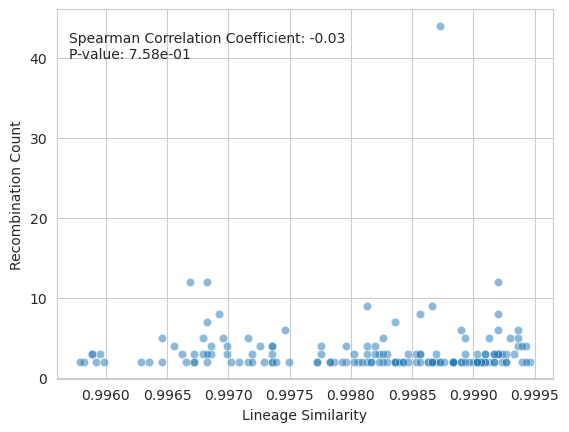

In [109]:
sns.scatterplot(data=recom_with_lineage_pair, x='similarity', y='count', alpha=0.5)

plt.xlabel('Lineage Similarity')
plt.ylabel('Recombination Count')
plt.text(0.9957, 40, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}', fontsize=10)

plt.savefig('../results/reviewer_1_5.pdf')
plt.show()

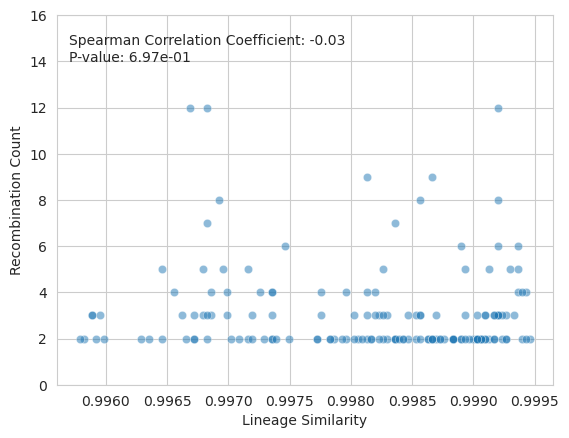

In [110]:
recom_with_lineage_pair = recom_with_lineage_pair[recom_with_lineage_pair['count'] < 40]
spearman_result = spearmanr(recom_with_lineage_pair['similarity'], recom_with_lineage_pair['count'])

sns.scatterplot(data=recom_with_lineage_pair, x='similarity', y='count', alpha=0.5)

plt.ylim(0, 16)
plt.xlabel('Lineage Similarity')
plt.ylabel('Recombination Count')
plt.text(0.9957, 14, f'Spearman Correlation Coefficient: {spearman_result[0]:.2f}\nP-value: {spearman_result[1]:.2e}', fontsize=10)

plt.savefig('../results/reviewer_1_5_sub.pdf')
plt.show()